# Load in the Dataset + Packages

In [1]:
# Import dependencies
import pandas as pd
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

In [2]:
# Load data from excel
api_df = pd.read_excel("../../data/processed/preprocessed_train.xlsx")
api_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,Low


In [3]:
api_df.shape

(1316, 53)

In [4]:
# X, y split for train-set
X_train, y_train = api_df.drop(columns=["Risk_Label"]), api_df["Risk_Label"]

In [5]:
# X, y split for test-set
test_df = pd.read_excel("../../data/processed/preprocessed_test.xlsx")
X_test, y_test = test_df.drop(columns=["Risk_Label"]), test_df["Risk_Label"]

In [6]:
y_train.value_counts()

Medium    661
Low       651
High        4
Name: Risk_Label, dtype: int64

In [7]:
# Smote function
def create_smote(X, y, k_neighbors):
    oversample = SMOTE(k_neighbors = k_neighbors)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [8]:
# Balance training data
X_train, y_train = create_smote(X_train, y_train, 2)

# Helper Code

In [9]:
results = {}
scoring_metric = ["accuracy", "f1_macro", "recall_macro"]

In [10]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# Baseline Performance

In [11]:
# Dummy Classifier Model
model_dummy = DummyClassifier(strategy="stratified", random_state=42)
results["Dummy"] = mean_std_cross_val_scores(
    model_dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy
fit_time,0.001 (+/- 0.000)
score_time,0.003 (+/- 0.000)
test_accuracy,0.342 (+/- 0.019)
train_accuracy,0.331 (+/- 0.010)
test_f1_macro,0.342 (+/- 0.019)
train_f1_macro,0.331 (+/- 0.010)
test_recall_macro,0.342 (+/- 0.019)
train_recall_macro,0.331 (+/- 0.010)


In [12]:
# KNN Classifier Model
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
results["KNN"] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN
fit_time,0.001 (+/- 0.000),0.004 (+/- 0.000)
score_time,0.003 (+/- 0.000),0.010 (+/- 0.001)
test_accuracy,0.342 (+/- 0.019),0.906 (+/- 0.011)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.004)
test_f1_macro,0.342 (+/- 0.019),0.906 (+/- 0.010)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003)
test_recall_macro,0.342 (+/- 0.019),0.906 (+/- 0.011)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.004)


In [13]:
# SVM Classifier Model
pipe_svm = make_pipeline(StandardScaler(), SVC(gamma=0.01))
results["SVM"] = mean_std_cross_val_scores(
    pipe_svm, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM
fit_time,0.001 (+/- 0.000),0.004 (+/- 0.000),0.020 (+/- 0.001)
score_time,0.003 (+/- 0.000),0.010 (+/- 0.001),0.016 (+/- 0.001)
test_accuracy,0.342 (+/- 0.019),0.906 (+/- 0.011),0.981 (+/- 0.006)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.004),0.990 (+/- 0.002)
test_f1_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.981 (+/- 0.006)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.990 (+/- 0.002)
test_recall_macro,0.342 (+/- 0.019),0.906 (+/- 0.011),0.981 (+/- 0.006)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.990 (+/- 0.002)


In [14]:
# Logistic Regression Classifier Model
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["LR"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR
fit_time,0.001 (+/- 0.000),0.004 (+/- 0.000),0.020 (+/- 0.001),0.019 (+/- 0.002)
score_time,0.003 (+/- 0.000),0.010 (+/- 0.001),0.016 (+/- 0.001),0.005 (+/- 0.002)
test_accuracy,0.342 (+/- 0.019),0.906 (+/- 0.011),0.981 (+/- 0.006),0.995 (+/- 0.003)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.004),0.990 (+/- 0.002),0.999 (+/- 0.000)
test_f1_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.981 (+/- 0.006),0.995 (+/- 0.003)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.990 (+/- 0.002),0.999 (+/- 0.000)
test_recall_macro,0.342 (+/- 0.019),0.906 (+/- 0.011),0.981 (+/- 0.006),0.995 (+/- 0.003)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.990 (+/- 0.002),0.999 (+/- 0.000)


# Hyperparameter Optimization

In [15]:
# Hyperparameter search for LogisticRegression
param_grid = {"logisticregression__C": [100, 10, 1.0, 0.1, 0.01],
             "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear']}

grid_search = GridSearchCV(
    pipe_lr, param_grid, cv=20, n_jobs=-1, return_train_score=True
)
results_gs = grid_search.fit(X_train, y_train)

/Users/sonchau/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sonchau/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

In [16]:
grid_search.best_score_

0.9954646464646466

In [17]:
grid_search.best_params_

{'logisticregression__C': 1.0, 'logisticregression__solver': 'newton-cg'}

In [18]:
# Hyperparameter search for KNN
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"n_neighbors": np.arange(5, 500, 5)}

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std()) 

results_df = pd.DataFrame(results_dict)

<AxesSubplot:xlabel='n_neighbors'>

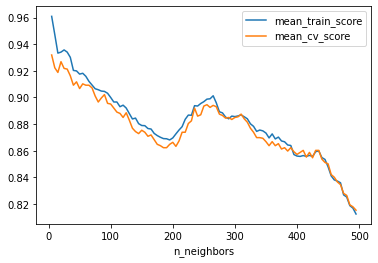

In [19]:
results_df.plot(x="n_neighbors", y=["mean_train_score", "mean_cv_score"])

In [20]:
results_df["train_cv_diff"] = results_df["mean_train_score"] - results_df["mean_cv_score"] 
results_df.head(20)

,n_neighbors,mean_train_score,mean_cv_score,std_cv_score,std_train_score,train_cv_diff
0,5,0.960918,0.931909,0.016859,0.003288,0.029009
1,10,0.947302,0.922332,0.011704,0.006136,0.024970
2,15,0.933308,0.918809,0.005850,0.005678,0.014499
3,20,0.934065,0.926875,0.009465,0.003205,0.007190
4,25,0.935704,0.921829,0.012284,0.002782,0.013875
5,30,0.934065,0.921332,0.013088,0.006319,0.012733
6,35,0.930157,0.916290,0.009742,0.003014,0.013866
7,40,0.920325,0.909226,0.014877,0.008028,0.011099
8,45,0.919945,0.911756,0.014827,0.006621,0.008189
9,50,0.917549,0.906701,0.012189,0.004869,0.010849


# Performance of Optimized Models

In [21]:
# KNN classifier with n_neighbors=20
k = 20
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
results["KNN_tuned"] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR,KNN_tuned
fit_time,0.001 (+/- 0.000),0.004 (+/- 0.000),0.020 (+/- 0.001),0.019 (+/- 0.002),0.004 (+/- 0.001)
score_time,0.003 (+/- 0.000),0.010 (+/- 0.001),0.016 (+/- 0.001),0.005 (+/- 0.002),0.012 (+/- 0.002)
test_accuracy,0.342 (+/- 0.019),0.906 (+/- 0.011),0.981 (+/- 0.006),0.995 (+/- 0.003),0.851 (+/- 0.021)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.004),0.990 (+/- 0.002),0.999 (+/- 0.000),0.877 (+/- 0.009)
test_f1_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.981 (+/- 0.006),0.995 (+/- 0.003),0.850 (+/- 0.022)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.990 (+/- 0.002),0.999 (+/- 0.000),0.876 (+/- 0.009)
test_recall_macro,0.342 (+/- 0.019),0.906 (+/- 0.011),0.981 (+/- 0.006),0.995 (+/- 0.003),0.851 (+/- 0.021)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.990 (+/- 0.002),0.999 (+/- 0.000),0.877 (+/- 0.009)


In [22]:
# Logistic Regression Classifier Model
pipe_lr_tuned = make_pipeline(StandardScaler(), LogisticRegression(C=100.0, solver='liblinear'))
results["LR_tuned"] = mean_std_cross_val_scores(
    pipe_lr_tuned, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR,KNN_tuned,LR_tuned
fit_time,0.001 (+/- 0.000),0.004 (+/- 0.000),0.020 (+/- 0.001),0.019 (+/- 0.002),0.004 (+/- 0.001),0.035 (+/- 0.002)
score_time,0.003 (+/- 0.000),0.010 (+/- 0.001),0.016 (+/- 0.001),0.005 (+/- 0.002),0.012 (+/- 0.002),0.004 (+/- 0.000)
test_accuracy,0.342 (+/- 0.019),0.906 (+/- 0.011),0.981 (+/- 0.006),0.995 (+/- 0.003),0.851 (+/- 0.021),0.993 (+/- 0.005)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.004),0.990 (+/- 0.002),0.999 (+/- 0.000),0.877 (+/- 0.009),0.998 (+/- 0.000)
test_f1_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.981 (+/- 0.006),0.995 (+/- 0.003),0.850 (+/- 0.022),0.993 (+/- 0.005)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.990 (+/- 0.002),0.999 (+/- 0.000),0.876 (+/- 0.009),0.998 (+/- 0.000)
test_recall_macro,0.342 (+/- 0.019),0.906 (+/- 0.011),0.981 (+/- 0.006),0.995 (+/- 0.003),0.851 (+/- 0.021),0.993 (+/- 0.005)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.004),0.990 (+/- 0.002),0.999 (+/- 0.000),0.877 (+/- 0.009),0.998 (+/- 0.000)


# Test Set prediction

In [23]:
# Data sub-set of features identified using RFE method
X_select = X_train[['is_pii', 'is_fii', 'authentication_processed', 'Information & Science',
       'x0_Broken Authentication', 'x0_Missing', 'server', 'metadata_fields_count']]

In [24]:
pipe_lr_tuned = make_pipeline(StandardScaler(), LogisticRegression(C=100.0, solver='liblinear'))
pipe_lr_tuned.fit(X_select, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=100.0, solver='liblinear'))])

In [25]:
X_testselect = X_test[['is_pii', 'is_fii', 'authentication_processed', 'Information & Science',
       'x0_Broken Authentication', 'x0_Missing', 'server', 'metadata_fields_count']]

In [26]:
y_pred = pipe_lr_tuned.predict(X_testselect)

In [27]:
pipe_lr_tuned.score(X_testselect, y_test)

0.9929203539823008